In [12]:
!nvidia-smi


zsh:1: command not found: nvidia-smi


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # Global features
        self.global_features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 128)
        )
        # Local features with adaptive pooling
        self.local_features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((8, 8))  # downsample to 8x8
        )

    def forward(self, x):
        return self.global_features(x), self.local_features(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Adjust the combined linear input size
        self.combine = nn.Sequential(
            nn.Linear(192, 512),  # Adjusted input size
            nn.ReLU(),
            nn.Linear(512, 1)  # Binary classification: real or fake
        )

    def forward(self, global_features, local_features):
        # Tile global features to have spatial dimensions of [8, 8]
        global_features_tiled = global_features.unsqueeze(2).unsqueeze(3).repeat(1, 1, 8, 8)
        combined = torch.cat([global_features_tiled, local_features], dim=1)
        combined = combined.view(combined.size(0) * combined.size(2) * combined.size(3), -1)  # Reshape for linear layers
        return self.combine(combined).squeeze()




In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
import numpy as np
import matplotlib.pyplot as plt  # Make sure this line is included
from torch import nn, optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torchvision.datasets import ImageFolder


# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

from torchvision.datasets import ImageFolder
from torch.utils.data import random_split

def is_png_file(filename):
    return filename.endswith('.png')

full_dataset = torchvision.datasets.ImageFolder(root='/Users/sadianasrintisha/Desktop/data', transform=transform,is_valid_file=is_png_file)

train_size = int(0.8 * len(full_dataset))  # Let's say you want 80% for training
test_size = len(full_dataset) - train_size

unlabeled_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

unlabeled_dataloader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



encoder = Encoder().to(device)
discriminator = Discriminator().to(device)

encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.001)
encoder_scheduler = StepLR(encoder_optimizer, step_size=10, gamma=0.7)
discriminator_scheduler = StepLR(discriminator_optimizer, step_size=10, gamma=0.7)
criterion = nn.BCEWithLogitsLoss()




cpu


In [15]:
print(f"Size of unlabeled (train) dataset: {len(unlabeled_dataset)} samples")
print(f"Size of test dataset: {len(test_dataset)} samples")


Size of unlabeled (train) dataset: 70439 samples
Size of test dataset: 17610 samples


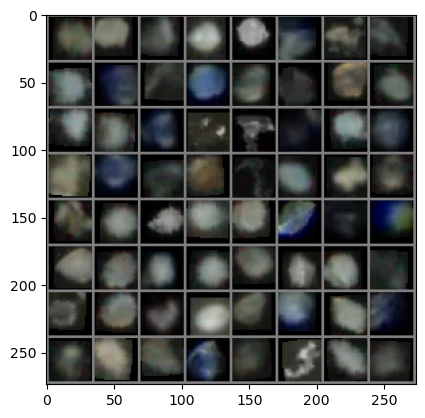

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision  # Make sure to import torchvision

# Take a batch of data and convert it to grid
dataiter = iter(unlabeled_dataloader)
images, _ = dataiter.__next__()  # Changed this line
grid = torchvision.utils.make_grid(images)

# Function to un-normalize and display the image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display
imshow(grid)



In [17]:
num_epochs = 50
losses = []  # Add this before the training loop

for epoch in range(num_epochs):
    for images, _ in unlabeled_dataloader:
        images = images.to(device)
        global_features, local_features = encoder(images)

        # Positive samples: local and global features from the same image
        positive_labels = torch.ones(local_features.size(0) * local_features.size(2) * local_features.size(3), device=device)
        positive_predictions = discriminator(global_features, local_features)

        # Negative samples: mix local features and global features
        negative_labels = torch.zeros(local_features.size(0) * local_features.size(2) * local_features.size(3), device=device)
        negative_predictions = discriminator(global_features[torch.randperm(local_features.size(0))], local_features)

        # Compute loss and update weights
        loss_positive = criterion(positive_predictions, positive_labels)
        loss_negative = criterion(negative_predictions, negative_labels)

        loss = loss_positive + loss_negative
        losses.append(loss.item())


        encoder_optimizer.zero_grad()
        discriminator_optimizer.zero_grad()
        loss.backward()
        encoder_optimizer.step()
        discriminator_optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")



Epoch 1/50, Loss: 1.3683855533599854
Epoch 2/50, Loss: 1.3672010898590088
Epoch 3/50, Loss: 1.3654506206512451
Epoch 4/50, Loss: 1.3660968542099
Epoch 5/50, Loss: 1.3670995235443115
Epoch 6/50, Loss: 1.368761658668518
Epoch 7/50, Loss: 1.3670796155929565
Epoch 8/50, Loss: 1.3657338619232178
Epoch 9/50, Loss: 1.3678032159805298
Epoch 10/50, Loss: 1.3655439615249634
Epoch 11/50, Loss: 1.364843487739563
Epoch 12/50, Loss: 1.3653371334075928
Epoch 13/50, Loss: 1.3670769929885864
Epoch 14/50, Loss: 1.3651982545852661
Epoch 15/50, Loss: 1.3678369522094727
Epoch 16/50, Loss: 1.3682115077972412
Epoch 17/50, Loss: 1.3655457496643066
Epoch 18/50, Loss: 1.366937279701233
Epoch 19/50, Loss: 1.3690226078033447
Epoch 20/50, Loss: 1.3671784400939941
Epoch 21/50, Loss: 1.3687212467193604
Epoch 22/50, Loss: 1.3683300018310547
Epoch 23/50, Loss: 1.3662315607070923
Epoch 24/50, Loss: 1.3683806657791138
Epoch 25/50, Loss: 1.366654872894287
Epoch 26/50, Loss: 1.3677263259887695
Epoch 27/50, Loss: 1.3709472

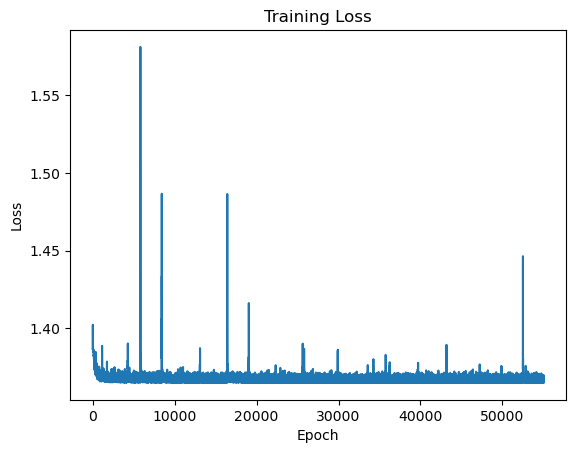

In [18]:
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [19]:
##used MLP

losses_1 = []
class Classifier(nn.Module):
    def __init__(self, num_classes=2):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(128, 512),  # Increased the number of neurons
            nn.ReLU(),
            nn.Dropout(p=0.5),   # Added dropout for regularization
            nn.Linear(512, 256), # Added an additional hidden layer
            nn.ReLU(),
            nn.Dropout(p=0.5),   # Added another dropout layer
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.network(x)

# Unfreeze encoder parameters for fine-tuning
for param in encoder.parameters():
    param.requires_grad = True


classifier = Classifier().to(device)
classifier_optimizer = optim.Adam(classifier.parameters(), lr=0.001)
classification_criterion = nn.CrossEntropyLoss()

labeled_dataloader = torch.utils.data.DataLoader(
    ImageFolder(root='/Users/sadianasrintisha/Desktop/data', transform=transform),
    batch_size=64, shuffle=True
)


num_epochs_classifier = 50

for epoch in range(num_epochs_classifier):
    for images, labels in labeled_dataloader:
        images, labels = images.to(device), labels.to(device)
        global_features, _ = encoder(images)
        predictions = classifier(global_features)
        loss = classification_criterion(predictions, labels)

        losses_1.append(loss.item())

        classifier_optimizer.zero_grad()
        loss.backward()
        classifier_optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs_classifier}, Loss: {loss.item()}")





Epoch 1/50, Loss: 0.6470065116882324
Epoch 2/50, Loss: 0.6816303730010986
Epoch 3/50, Loss: 0.6559271812438965
Epoch 4/50, Loss: 0.6644231081008911
Epoch 5/50, Loss: 0.6492800712585449
Epoch 6/50, Loss: 0.6871762871742249
Epoch 7/50, Loss: 0.5712217092514038
Epoch 8/50, Loss: 0.6205368638038635
Epoch 9/50, Loss: 0.6344330906867981
Epoch 10/50, Loss: 0.5477089285850525
Epoch 11/50, Loss: 0.5751734972000122
Epoch 12/50, Loss: 0.6596361994743347
Epoch 13/50, Loss: 0.6213531494140625
Epoch 14/50, Loss: 0.7600435018539429
Epoch 15/50, Loss: 0.6200689673423767
Epoch 16/50, Loss: 0.6695076823234558
Epoch 17/50, Loss: 0.6551859974861145
Epoch 18/50, Loss: 0.5456032156944275
Epoch 19/50, Loss: 0.571778416633606
Epoch 20/50, Loss: 0.6027007699012756
Epoch 21/50, Loss: 0.5509674549102783
Epoch 22/50, Loss: 0.5733111500740051
Epoch 23/50, Loss: 0.534508466720581
Epoch 24/50, Loss: 0.7907593250274658
Epoch 25/50, Loss: 0.5781197547912598
Epoch 26/50, Loss: 0.6382097005844116
Epoch 27/50, Loss: 0.58

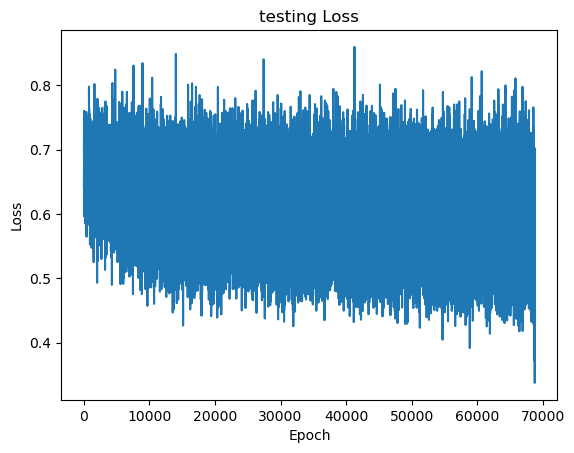

In [20]:
plt.plot(losses_1)
plt.title('testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [21]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

encoder.eval()
classifier.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        global_features, _ = encoder(images)
        predictions = classifier(global_features)
        _, predicted = torch.max(predictions.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test images: {100 * correct / total}%')





Accuracy of the network on test images: 74.6053378762067%


Classification Report:
              precision    recall  f1-score   support

      Class1       0.77      0.74      0.75      8930
      Class2       0.74      0.77      0.75      8680

    accuracy                           0.75     17610
   macro avg       0.75      0.75      0.75     17610
weighted avg       0.75      0.75      0.75     17610



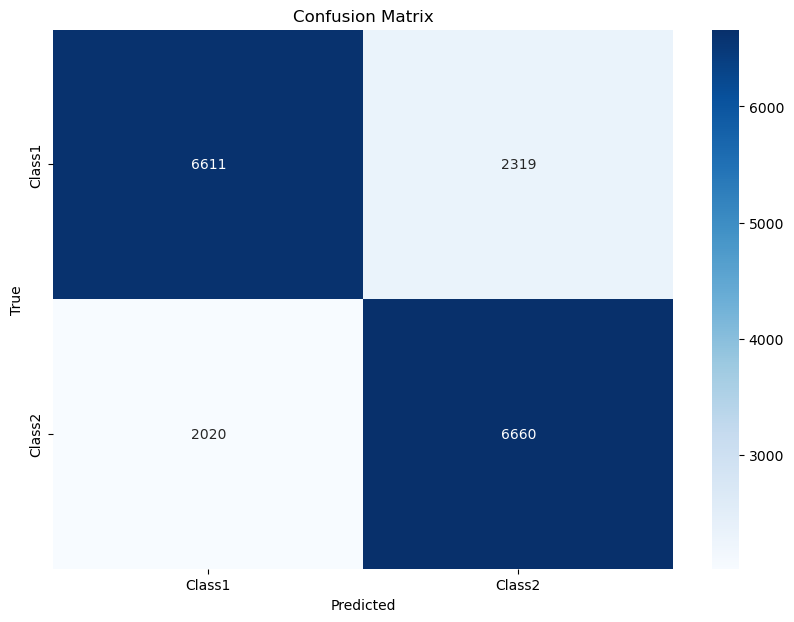

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store predictions and labels
all_preds = []
all_labels = []

# Iterate over test data to get predictions and true labels
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        global_features, _ = encoder(images)
        predictions = classifier(global_features)
        _, predicted = torch.max(predictions.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate the classification report and confusion matrix
report = classification_report(all_labels, all_preds, target_names=["Class1", "Class2"])  # Replace "Class1" and "Class2" with your actual class names
conf_matrix = confusion_matrix(all_labels, all_preds)

# Print classification report
print("Classification Report:")
print(report)

# Plot confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=["Class1", "Class2"], yticklabels=["Class1", "Class2"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
